# Final Project Group 2
## Group Members:
- Ridha Fuady
- William Hugo
- Irfan Fahmudin 
- Al Izhar Iqrami

## Dataset
https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images?select=data

## Objective
Untuk predict tipe fashion produk user yang nanti akan digunakan untuk rekomendasi sistem kami

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# navigasi ke folder
% cd /content/gdrive/My Drive/data_fashion

## IMPORT LIBRARY

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

## DATA LOADING

In [ ]:
main_dir = pathlib.Path("/content/gdrive/MyDrive/data_fashion")
class_names = np.array(sorted([item.name for item in main_dir.glob('*')]))
print(class_names)

['143694234-97057406-1627033768.jpg'
 '2017-fashion-classic-embossed-striped-shirts-500x500 (1).png'
 '2211 (1).jpg' '2211.jpg' 'Apparel Set' 'Bottomwear' 'Dress' 'Flipflop'
 'Innerwear' 'Sandal' 'Shoes' 'Socks' 'Topwear'
 'celana_pendek_thom_browne_1629559010_3a03df1d_progressive.jpg'
 'my_model.h5' 'my_model_imp.h5' 'wio-8-road-running-shoes-S6jPM3 (1).jpg']


In [ ]:
def visualize_image(target_class):
  target_folder = '/content/gdrive/MyDrive/data_fashion//' + target_class

  # pick a random samples
  random_image = random.sample(os.listdir(target_folder), 1)

  img = cv2.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Ukuran Gambar: {img.shape}")
  return img

Ukuran Gambar: (2400, 1800, 3)


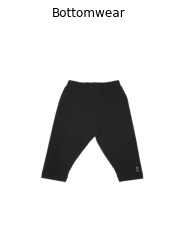

In [ ]:
# melihat data
img = visualize_image(target_class='Bottomwear')

Ukuran Gambar: (2400, 1800, 3)


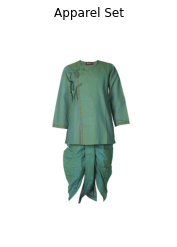

In [ ]:
# melihat data
img = visualize_image(target_class='Apparel Set')

## DATA PREPROCESSING

In [ ]:
# set the parameter

batch_size = 32
img_height = 250
img_width = 250

In [ ]:
# split data into train and val

train_data = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/data_fashion", validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width),batch_size=batch_size, color_mode='grayscale')

val_data = tf.keras.preprocessing.image_dataset_from_directory("/content/gdrive/MyDrive/data_fashion", validation_split=0.2,subset="validation",seed=123,image_size= (img_height, img_width),batch_size=batch_size, color_mode='grayscale')

Found 2905 files belonging to 9 classes.
Using 2324 files for training.
Found 2905 files belonging to 9 classes.
Using 581 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# membuat fungsi untuk augmentasi data
def aug_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

In [ ]:
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
train_data = train_data.map(aug_pipeline, num_parallel_calls=AUTOTUNE)

val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
# val_data = val_data.map(aug_pipeline, num_parallel_calls=AUTOTUNE)

In [ ]:
# rescaling data agar berada pada rentang 0-1
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [ ]:
for image, label in train_data.take(1):
  print("Image shape: ", image.numpy().shape)

Image shape:  (32, 250, 250, 1)


## BUILD MODEL

In [ ]:
# mendefinisikan fungsi callback
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 3, verbose=1),
            ModelCheckpoint('bestmodel_47.hdf5', monitor='val_loss')]
# input= [img_height,img_width,3]
input= [img_height,img_width,1] # Kalau pake grayscale

In [ ]:
#konvolusi 1
model= Sequential()
model.add(Conv2D(filters=32, kernel_size=2, activation= 'relu', input_shape= input))
model.add(MaxPooling2D(pool_size=4, strides=4))

#konvolusi 2
model.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', padding='same' ))
model.add(MaxPooling2D(pool_size=3, strides=3))
model.add(tf.keras.layers.Dropout(rate=0.5))

#konvolusi 3
model.add(Conv2D(filters=64, kernel_size=4, activation= 'relu' , padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Dropout(rate=0.5))

#konvolusi 4
model.add(Conv2D(filters=128, kernel_size=2, activation= 'relu' , padding='same'))
model.add(tf.keras.layers.Dropout(rate=0.5))

# flatten
model.add(Flatten())
model.add(Dense(units=256, activation= 'relu'))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(Dense(units=128, activation= 'relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))


model.add(Dense(units=9, activation= 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 20, 20, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        6

In [ ]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, validation_data = val_data, callbacks = callbacks, epochs=50)

Epoch 1/50
73/73 [==============================] - 736s 10s/step - loss: 6.9056 - accuracy: 0.3386 - val_loss: 1.6515 - val_accuracy: 0.6472
Epoch 2/50
73/73 [==============================] - 4s 54ms/step - loss: 1.3132 - accuracy: 0.5581 - val_loss: 1.1176 - val_accuracy: 0.7281
Epoch 3/50
73/73 [==============================] - 3s 41ms/step - loss: 1.0414 - accuracy: 0.6330 - val_loss: 0.9380 - val_accuracy: 0.7539
Epoch 4/50
73/73 [==============================] - 3s 41ms/step - loss: 0.8988 - accuracy: 0.6902 - val_loss: 0.8754 - val_accuracy: 0.7642
Epoch 5/50
73/73 [==============================] - 3s 41ms/step - loss: 0.8440 - accuracy: 0.7070 - val_loss: 0.9438 - val_accuracy: 0.7814
Epoch 6/50
73/73 [==============================] - 3s 41ms/step - loss: 0.8109 - accuracy: 0.7070 - val_loss: 0.8350 - val_accuracy: 0.7952
Epoch 7/50
73/73 [==============================] - 3s 41ms/step - loss: 0.7634 - accuracy: 0.7324 - val_loss: 0.8455 - val_accuracy: 0.7866
Epoch 8/50
7

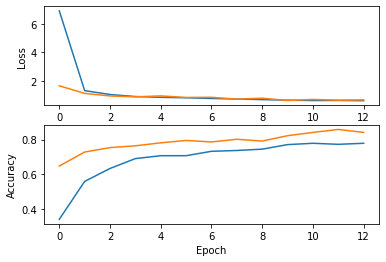

In [ ]:
#Visualising the training and validation loss
fig, axs = plt.subplots(2,1)
axs[0].plot(range(13),history.history['loss'],label='train loss')
axs[0].plot(range(13),history.history['val_loss'],label='val loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(range(13),history.history['accuracy'],label='train acc')
axs[1].plot(range(13),history.history['val_accuracy'],label='val acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
plt.show()

## Model Improvement

In [ ]:
#konvolusi 1
model_imp= Sequential()
model_imp.add(Conv2D(filters=32, kernel_size=2, activation= 'relu', input_shape= input))
model_imp.add(MaxPooling2D(pool_size=4, strides=4))

#konvolusi 2
model_imp.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', padding='valid' ))
model_imp.add(MaxPooling2D(pool_size=3, strides=3))
model_imp.add(tf.keras.layers.Dropout(rate=0.5))
model_imp.add(tf.keras.layers.BatchNormalization())

#konvolusi 3
model_imp.add(Conv2D(filters=64, kernel_size=4, activation= 'relu' , padding='same'))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))
model_imp.add(tf.keras.layers.Dropout(rate=0.5))
model_imp.add(tf.keras.layers.BatchNormalization())

#konvolusi 4
model_imp.add(Conv2D(filters=128, kernel_size=2, activation= 'relu' , padding='same'))
model_imp.add(tf.keras.layers.Dropout(rate=0.5))
model_imp.add(tf.keras.layers.BatchNormalization())

# flatten
model_imp.add(Flatten())
model_imp.add(Dense(units=256, activation= 'relu'))
model_imp.add(tf.keras.layers.Dropout(rate=0.3))
model_imp.add(Dense(units=128, activation= 'relu'))
model_imp.add(tf.keras.layers.Dropout(rate=0.3))


model_imp.add(Dense(units=9, activation= 'softmax'))

In [ ]:
model_imp.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 249, 249, 32)      160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 batch_normalization_9 (Batc  (None, 20, 20, 64)      

In [ ]:
model_imp.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history_imp = model_imp.fit(train_data, validation_data = val_data, callbacks = callbacks, epochs=50)

Epoch 1/50
73/73 [==============================] - 5s 55ms/step - loss: 1.5187 - accuracy: 0.5090 - val_loss: 0.7807 - val_accuracy: 0.7556
Epoch 2/50
73/73 [==============================] - 3s 42ms/step - loss: 0.9588 - accuracy: 0.6579 - val_loss: 0.6182 - val_accuracy: 0.7676
Epoch 3/50
73/73 [==============================] - 3s 41ms/step - loss: 0.8077 - accuracy: 0.7177 - val_loss: 0.5403 - val_accuracy: 0.7917
Epoch 4/50
73/73 [==============================] - 3s 41ms/step - loss: 0.6889 - accuracy: 0.7466 - val_loss: 0.5292 - val_accuracy: 0.7952
Epoch 5/50
73/73 [==============================] - 3s 41ms/step - loss: 0.6134 - accuracy: 0.7793 - val_loss: 0.5615 - val_accuracy: 0.7831
Epoch 6/50
73/73 [==============================] - 3s 41ms/step - loss: 0.5700 - accuracy: 0.7960 - val_loss: 0.4680 - val_accuracy: 0.8055
Epoch 7/50
73/73 [==============================] - 3s 42ms/step - loss: 0.5296 - accuracy: 0.8223 - val_loss: 0.4781 - val_accuracy: 0.8003
Epoch 8/50
73

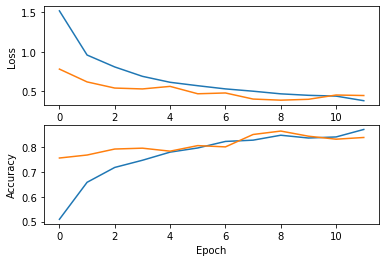

In [ ]:
fig, axs = plt.subplots(2,1)
axs[0].plot(range(12),history_imp.history['loss'],label='train loss')
axs[0].plot(range(12),history_imp.history['val_loss'],label='val loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(range(12),history_imp.history['accuracy'],label='train acc')
axs[1].plot(range(12),history_imp.history['val_accuracy'],label='val acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
plt.show()

## Model Saving

In [ ]:
model.save("my_model.h5")
model_imp.save("my_model_imp.h5")

In [ ]:
# model.save("final")

## MODEL LOADING

In [ ]:
new_model_loading.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 249, 249, 32)      160       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 20, 64)      

In [ ]:
new_model_loading = tf.keras.models.load_model('my_model_imp.h5')

In [ ]:
new_model_loading.save("final")

INFO:tensorflow:Assets written to: final/assets


## Model Inference

In [ ]:
prediction_dict = {0:'Apparel Set', 1:'Bottomwear', 2:'Dress', 3:'Flipflop', 4:'Innerwear', 5:'Sandal', 6:'Shoes', 7:'Socks', 8:'Topwear'}

Saving 2211.jpg to 2211 (3).jpg


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


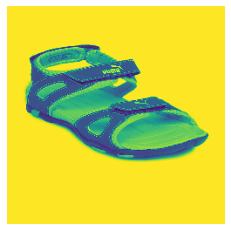

0.5350145 Sandal


In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(img_height,img_width),grayscale=True) 
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) 
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  #predictions = model_imp.predict(images)
  predictions = new_model_loading.predict(images)
  maxindex = int(np.argmax(predictions))
  print(predictions[0][maxindex],prediction_dict[maxindex])